#Import essential lib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Projects/Thesis/Pytorch')

In [ ]:
import early_ar
from AHD import *
from losses import *

In [ ]:
pip install facenet-pytorch

In [ ]:
# Import resources
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict
from collections import Counter

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from facenet_pytorch import MTCNN, InceptionResnetV1

from scipy.spatial import distance
import pandas as pd
import os

print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu102
0.10.0+cu102


#Set for Training

In [ ]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('GPU is NOT available')
else:
    print('GPU is AVAILABLE')

# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} GPU detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(f'Multi_GPUs: {multi_gpu}.')
device = torch.device("cuda:0" if train_on_gpu else "cpu")

GPU is AVAILABLE
1 GPU detected.
Multi_GPUs: False.


In [ ]:
data_dir = '/content/drive/MyDrive/Projects/Thesis/data/AR'
train_dir = data_dir + '/train_variation'
test_dir = data_dir + '/test'

In [ ]:
# Define your transforms for the training and testing sets
image_transforms = {
    'train_variation':
    transforms.Compose([
        transforms.ColorJitter(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # Imagenet standards

    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

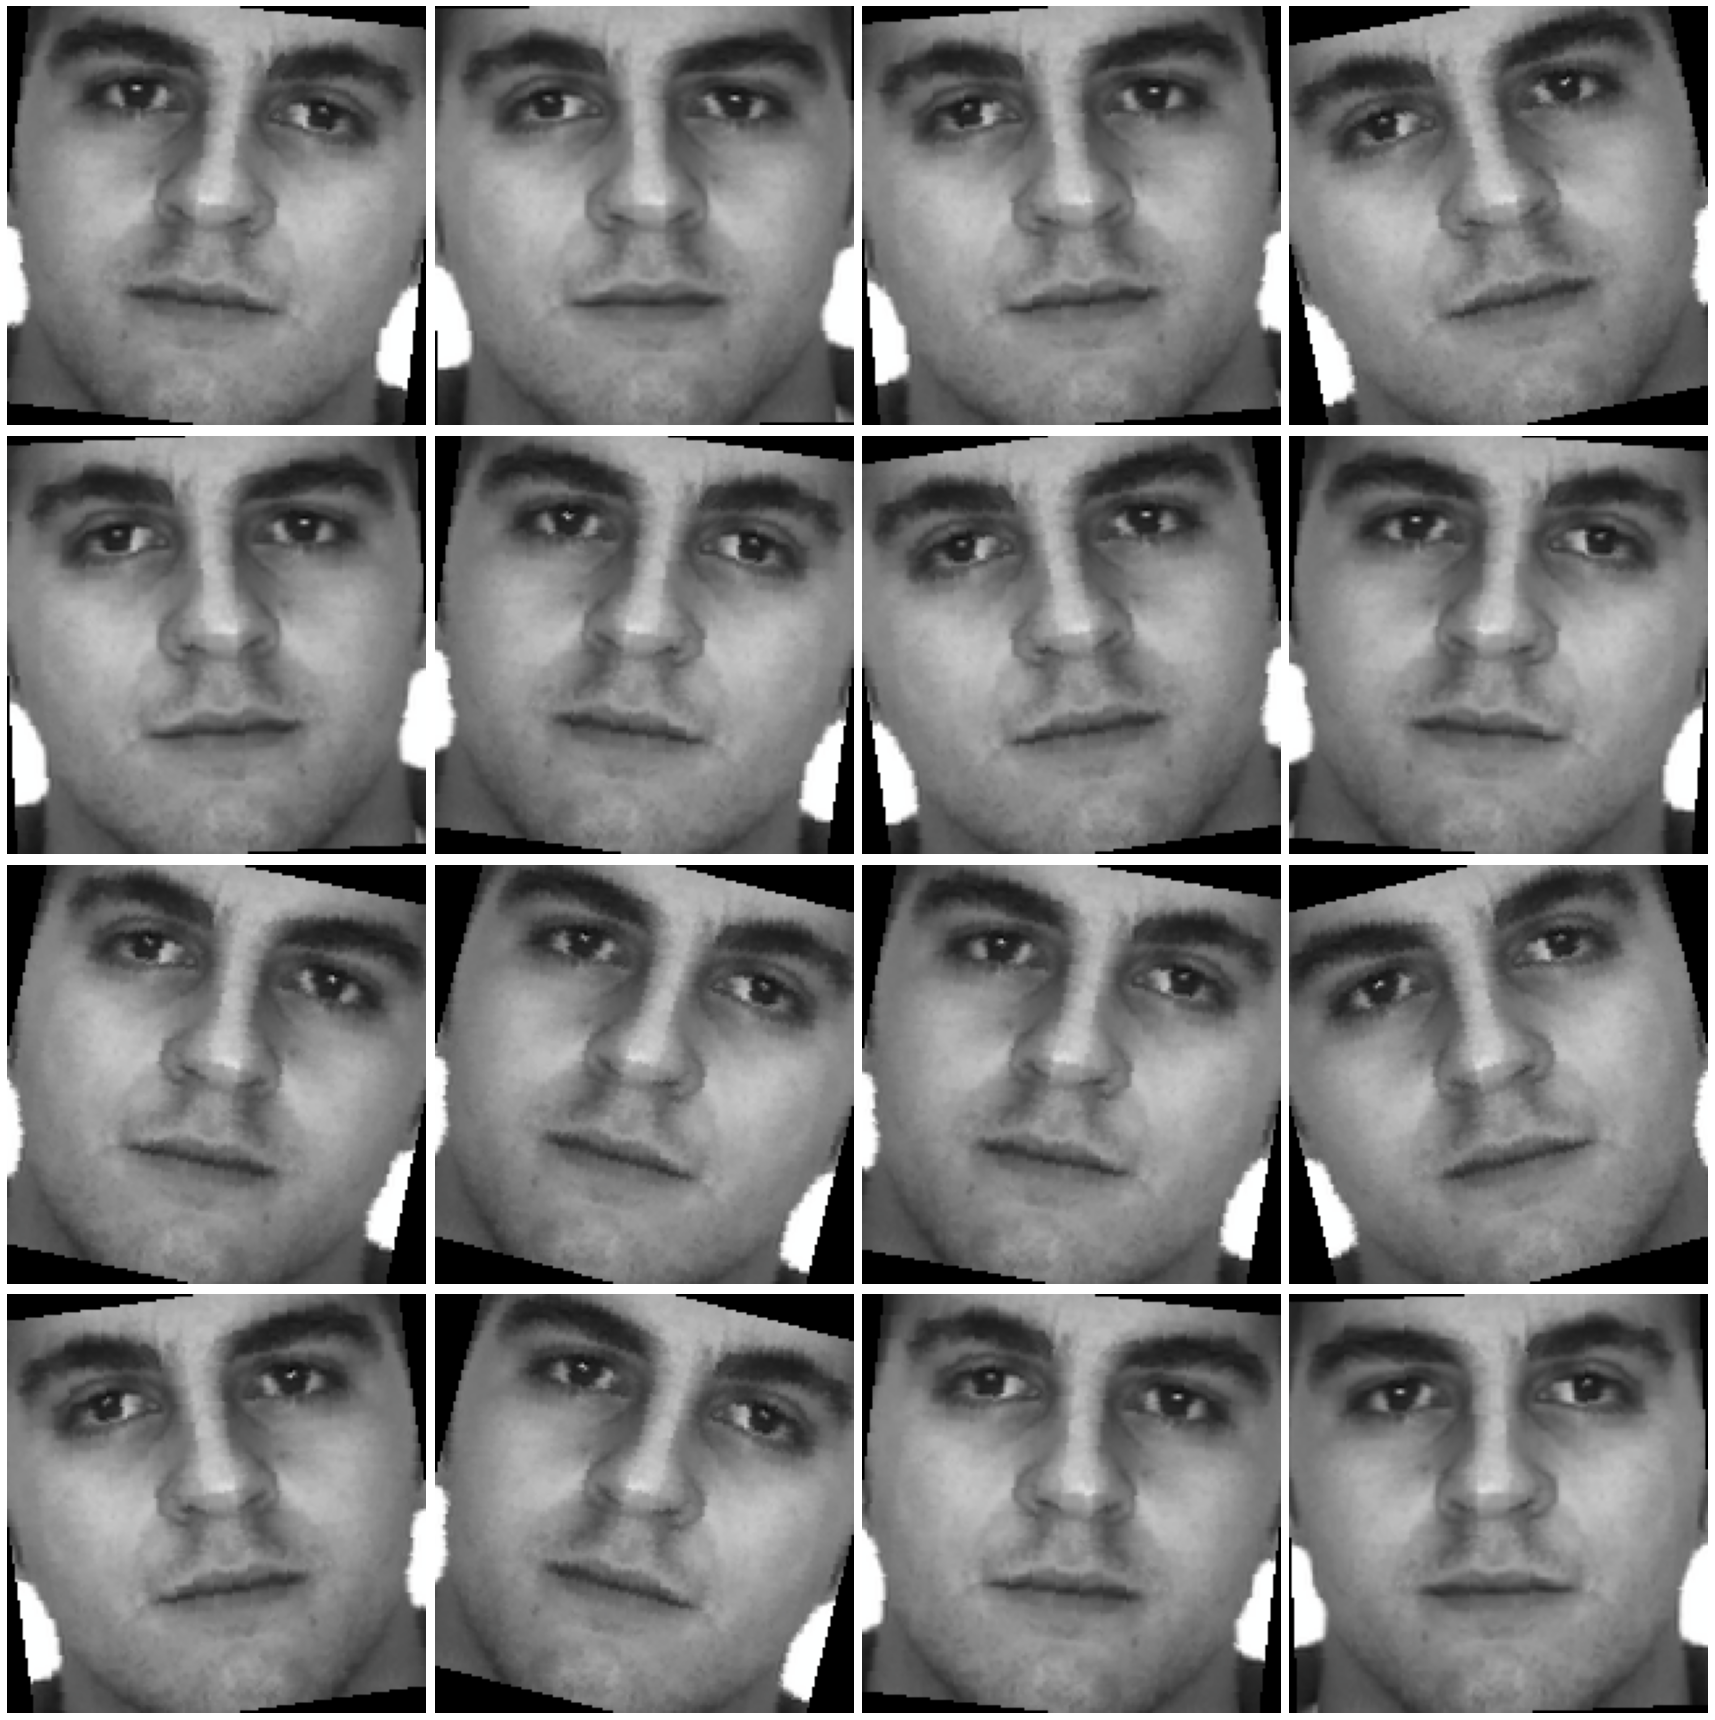

In [ ]:
ex_img = Image.open('/content/drive/MyDrive/Projects/Thesis/data/AR/train_variation/M-010-01/M-010-01.bmp')
ex_img = ex_img.convert('RGB')
t = image_transforms['train_variation']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [ ]:
# Datasets from folders
batch_size = 128

data = {
    'train_variation': datasets.ImageFolder(root=train_dir, transform=image_transforms['train_variation']),
    # 'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train_variation': DataLoader(data['train_variation'], batch_size=batch_size, shuffle=False,num_workers=2),
    # 'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=0),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=False,num_workers=2)
}

In [ ]:
dataset_sizes = {x: len(data[x]) for x in ['train_variation', 'test']}
print(dataset_sizes)
print(device)

{'train_variation': 1299, 'test': 100}
cuda:0


In [ ]:
# Iterate through the dataloader once
train_iter = iter(dataloaders['train_variation'])
features, labels = next(train_iter)
features.shape, labels.shape

(torch.Size([128, 3, 160, 160]), torch.Size([128]))

In [ ]:
class_names = []
for d in os.listdir(train_dir):
    class_names.append(d)
    
num_out_features = len(class_names)
print(f'There are {num_out_features} different classes. \n{class_names}')

There are 100 different classes. 
['M-001-01', 'M-008-01', 'M-010-01', 'M-005-01', 'M-006-01', 'M-007-01', 'M-003-01', 'M-004-01', 'M-009-01', 'M-002-01', 'M-011-01', 'M-013-01', 'M-017-01', 'M-019-01', 'M-018-01', 'M-012-01', 'M-020-01', 'M-014-01', 'M-016-01', 'M-015-01', 'M-021-01', 'M-022-01', 'M-027-01', 'M-028-01', 'M-023-01', 'M-030-01', 'M-029-01', 'M-031-01', 'M-024-01', 'M-026-01', 'M-025-01', 'M-032-01', 'M-033-01', 'M-039-01', 'M-034-01', 'M-037-01', 'M-041-01', 'M-036-01', 'M-035-01', 'M-040-01', 'M-042-01', 'M-038-01', 'M-043-01', 'M-044-01', 'M-045-01', 'M-048-01', 'W-002-01', 'M-049-01', 'M-046-01', 'W-004-01', 'M-050-01', 'W-001-01', 'W-003-01', 'M-047-01', 'W-005-01', 'W-007-01', 'W-009-01', 'W-013-01', 'W-014-01', 'W-006-01', 'W-010-01', 'W-008-01', 'W-011-01', 'W-012-01', 'W-015-01', 'W-016-01', 'W-019-01', 'W-023-01', 'W-020-01', 'W-025-01', 'W-021-01', 'W-022-01', 'W-018-01', 'W-017-01', 'W-024-01', 'W-035-01', 'W-031-01', 'W-032-01', 'W-027-01', 'W-026-01', 'W-02

In [ ]:
#Load pretrained model
model = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = num_out_features)

In [ ]:
list(model.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [ ]:
layer_list = list(model.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [ ]:
model = nn.Sequential(*list(model.children())[:-5])

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [ ]:
model.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model.logits = nn.Linear(layer_list[4].in_features, len(class_names))
model.softmax = nn.Softmax(dim=1)

In [ ]:
criterion = AveragedHausdorffLoss()
# # Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [ ]:
# Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, num_epochs, PATH):
    start_train = time.time()

    history = []
    loss_min = np.Inf
    train_losses = []

    best_epoch = 0
    #Initial EarlyStopping
    early_stopping = early_ar.EarlyStopping(patience=10, path=PATH, verbose=True)
    lst = [1] + [i*100 for i in range(1, 151)]
    for epoch in range(1, num_epochs + 1):
        # Train the model
        model.train()
        for inputs, labels in dataloaders['train_variation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            ###############################
            labels_list = labels.tolist()
            ground_truth = []
            for i in labels_list:
                element = [0]*num_out_features
                element[i] = 1
                if len(ground_truth) >= batch_size:
                  ground_truth.clear()
                ground_truth.append(element)
            ground_truth = (torch.Tensor(ground_truth)).to(device)
            ################################
            # ground_truth = torch.eye(100).to(device)
            ################################

            #Clear Gradient
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                # print('###################', ground_truth.size(), outputs.size())
                loss = criterion.forward(ground_truth, outputs)
                
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
            
            train_losses.append(loss.item())

        epoch_loss = np.average(train_losses)
        history.append([epoch_loss])
        if epoch in lst:
            print('-' * 10)
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('Train_Loss: {:.4f}'.format(epoch_loss))
            ################################
            # Saving the best loss
            if epoch_loss < loss_min:
                # Sava model
                print(f'loss decreased: {loss_min:.4f} ----> {epoch_loss:.4f}. Saving model.')
                torch.save({
                    'epoch': epoch,
                    'loss': loss_min,
                    'history': history,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, PATH)
                # Early Stopping
                patience = 10
                epochs_no_improve = 0
                loss_min = epoch_loss
                best_epoch = epoch
            else:
                epochs_no_improve += 1
                if epochs_no_improve < patience: 
                    print(f'EarlyStopping count: {epochs_no_improve}/{patience}')
                else:
                    print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {loss_min:.4f}')
                    break
            print()
            ###################################

    time_elapsed = time.time() - start_train
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Smallest loss: {:.3f} at epoch {}'.format(loss_min, best_epoch))
    # Format history
    history = pd.DataFrame(
        history,
        columns=['epoch_loss'])

    #Loaf the last checkpoint with the best model
    model.load_state_dict((torch.load(PATH))['model_state_dict'])
    return model, history

#Training

In [ ]:
PATH = '/content/drive/MyDrive/Projects/Thesis/Pytorch/weight/AR_vggface2.pth'
epochs = 15000
model.to(device)
model = train_model(model, criterion, optimizer, epochs, PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------
Epoch 1/15000
Train_Loss: 1.9893
loss decreased: inf ----> 1.9893. Saving model.

----------
Epoch 100/15000
Train_Loss: 1.9691
loss decreased: 1.9893 ----> 1.9691. Saving model.

----------
Epoch 200/15000
Train_Loss: 1.9348
loss decreased: 1.9691 ----> 1.9348. Saving model.

----------
Epoch 300/15000
Train_Loss: 1.8826
loss decreased: 1.9348 ----> 1.8826. Saving model.

----------
Epoch 400/15000
Train_Loss: 1.8162
loss decreased: 1.8826 ----> 1.8162. Saving model.

----------
Epoch 500/15000
Train_Loss: 1.7404
loss decreased: 1.8162 ----> 1.7404. Saving model.

----------
Epoch 600/15000
Train_Loss: 1.6574
loss decreased: 1.7404 ----> 1.6574. Saving model.

----------
Epoch 700/15000
Train_Loss: 1.5708
loss decreased: 1.6574 ----> 1.5708. Saving model.

----------
Epoch 800/15000
Train_Loss: 1.4835
loss decreased: 1.5708 ----> 1.4835. Saving model.

----------
Epoch 900/15000
Train_Loss: 1.3982
loss decreased: 1.4835 ----> 1.3982. Saving model.

----------
Epoch 1000/150

KeyboardInterrupt: ignored

#Load The Checkpoint

In [ ]:
PATH = '/content/drive/MyDrive/Projects/Thesis/Pytorch/weight/AR_vggface2.pth'
#Load checkpoint
def load_checkpoint(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    history = checkpoint['history']

    return model, loss, epoch, history 

model, loss, epoch, history = load_checkpoint(PATH)

# Visualization

Text(0.5, 1.0, 'Training Losses')

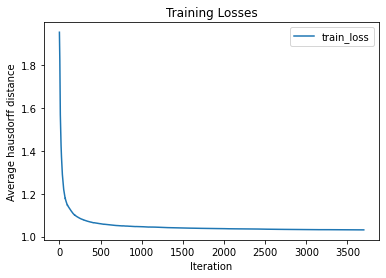

In [ ]:
plt.plot(history, label=c)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Average hausdorff distance')
plt.title('Training Losses')